# Velocity Dispersion Comparison with real data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import ctypes
from colossus.cosmology import cosmology
from scipy import interpolate
from scipy.interpolate import griddata

cosmo = cosmology.setCosmology('planck18')
omega_m = cosmo.Om0
H = cosmo.H0
ibc = ctypes.CDLL("../cmake-build-debug/lib/libfoo.so")

import GridVelocityDispersion as grd

In [2]:
deNicola = pd.read_csv("deNicolaData.csv", sep=',')

In [3]:
deNicola = deNicola[deNicola["stellar_mass"] != "null"]
deNicola

/home/chris/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Name,Morphology,A,Distance_Mpc,Distance_Error_Mpc,Black_Hole_Mass_Msun,Black_Hole_Mass_Error_Msun,velocity_dispersion_kms,velocity_dispersion_error_kms,Luminosity_Lsun,Luminosity_Error_Lsun,Radius_kpc,Radius_error_kpc,B,stellar_mass,Sersic_Index
0,Circinus,SABb:,3,2.82,0.47,6.23,0.10,1.900,0.020,10.00,0.12,-0.91,0.07,1,NaN,NaN
1,A1836,BCGE,0,152.40,8.40,9.57,0.06,2.460,0.020,11.75,0.06,0.89,0.02,0,NaN,NaN
2,IC1459,E4,0,28.90,3.70,9.39,0.08,2.520,0.010,11.70,0.06,0.90,0.06,1,NaN,NaN
3,NGC524,S0,2,24.20,2.20,8.94,0.05,2.390,0.020,10.52,0.08,0.17,0.07,1,NaN,NaN
4,NGC821,S0,1,23.40,1.80,8.22,0.21,2.320,0.020,10.84,0.31,0.33,0.03,1,11.00,6.0
5,NGC1023,SB0,2,10.81,0.80,7.62,0.06,2.310,0.020,10.45,0.07,-0.41,0.03,1,10.99,4.2
6,NGC1399,E1,0,20.85,0.67,8.95,0.31,2.498,0.004,11.81,0.06,1.53,0.01,1,NaN,NaN
7,NGC2273,SBa,3,29.50,1.90,6.93,0.04,2.100,0.030,10.43,0.40,-0.57,0.03,1,NaN,NaN
8,NGC2549,S0/,2,12.70,1.60,7.16,0.37,2.160,0.020,9.73,0.06,-0.72,0.06,1,NaN,NaN
9,NGC3115,S0/,2,9.54,0.40,8.95,0.10,2.360,0.020,10.93,0.06,0.20,0.06,1,10.93,4.7


In [4]:
Aperture = 0.5 # kpc
Beta = 0.1

rows = deNicola.shape[0]
halo_rs = 2000.
halo_c = 10.



In [5]:
def bernardi_k(n, Rre):
    
    bernardi_table = np.array([[7.38, 7.20, 6.80, 6.78, 6.97, 7.30],
                               [6.59, 6.46, 6.23, 6.36, 6.63, 6.97],
                               [5.84, 5.76, 5.69, 5.96, 6.27, 6.62],
                               [5.18, 5.15, 5.21, 5.57, 5.92, 6.27],
                               [4.62, 4.62, 4.79, 5.21, 5.58, 5.93],
                               [4.14, 4.17, 4.42, 4.88, 5.26, 5.60],
                               [3.74, 3.79, 4.09, 4.58, 4.95, 5.29],
                               [3.39, 3.46, 3.79, 4.29, 4.67, 4.99],
                               [3.10, 3.17, 3.52, 4.03, 4.40, 4.71],
                               [2.84, 2.92, 3.28, 3.78, 4.14, 4.44],
                               [2.61, 2.70, 3.06, 3.56, 3.91, 4.19],
                               [2.41, 2.50, 2.86, 3.35, 3.68, 3.95],
                               [2.23, 2.32, 2.68, 3.15, 3.47, 3.73],
                               [2.07, 2.16, 2.51, 2.96, 3.27, 3.52],
                               [1.92, 2.01, 2.36, 2.79, 3.08, 3.32],
                               [1.79, 1.88, 2.21, 2.63, 2.91, 3.13],
                               [1.67, 1.75, 2.08, 2.48, 2.74, 2.95]])
    
    if Rre < 0.1:
        Rre = 0.1

    bernardi_rre_range = np.array([0.1, 0.125, 0.25, 0.5, 0.75, 1])
    bernardi_n_range = np.array([2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00, 
                                 6.50, 7.00, 7.50, 8.00, 8.50, 9.00, 9.50, 10.00])

    bernardi_x = np.tile(bernardi_rre_range, len(bernardi_n_range)).ravel()
    bernardi_y = np.tile(np.vstack(bernardi_n_range), len(bernardi_rre_range)).ravel()


    bernardi_data = (bernardi_x, bernardi_y)
    sample = (Rre, n)
    grid2 = griddata(bernardi_data, bernardi_table.ravel(), sample, method='cubic')
    
    return grid2

In [17]:
ibc.VD.argtypes =   [ctypes.c_float, 
                     ctypes.c_float,
                     ctypes.c_float, 
                     ctypes.c_float,
                     ctypes.c_float, 
                     ctypes.c_float,
                     ctypes.c_float,
                     ctypes.c_float,
                     ctypes.c_float]

ibc.VD.restype = ctypes.c_float

VD_store = np.array([])
VD_bernardi_store = np.array([])
VD_grid_store = np.array([])

actual = np.array([])
preliminary = 10**deNicola["velocity_dispersion_kms"]



for index, row in deNicola.iterrows():
    

    
    radius = 10**row["Radius_kpc"]

    n = float(row["Sersic_Index"])
    sm = 10**float(row["stellar_mass"])
    
    if not np.isnan(n) or not np.isnan(sm):   
        print("New Galaxy")
        print('--n', n)
        print('--sm', sm, "log10", np.log10(sm))
        print('--radius', radius)

        if(radius > 2):
        
            Aperture = 1.5 * 4.84814e-6 * row["Distance_Mpc"] * 10**3

            VD = ibc.VD(Aperture, Beta, radius, n, sm, halo_rs, halo_c, omega_m, H)
            VD_store = np.append(VD_store, VD)

            VD_bernardi = ((4.3009125e-6*sm)/(bernardi_k(n, Aperture/radius) * radius))**0.5

            print(n, Aperture/radius)

            VD_bernardi_store = np.append(VD_bernardi_store, VD_bernardi)

            print(VD, VD_bernardi)

            VD_grid = grd.GetGridVelocityDispersion(Beta, radius, n, sm)
    
            VD_grid_store = np.append(VD_grid_store, VD_grid[0])
            actual = np.append(actual, preliminary[index])
    

New Galaxy
--n 6.0
--sm 100000000000.0 log10 11.0
--radius 2.137962089502232
6.0 0.07959435522059209
261.7303161621094 254.74135623382958
New Galaxy
--n 4.2
--sm 97723722095.58112 log10 10.99
--radius 0.3890451449942806
New Galaxy
--n 4.7
--sm 85113803820.2376 log10 10.93
--radius 1.5848931924611136
New Galaxy
--n 5.9
--sm 31622776601.683792 log10 10.5
--radius 3.311311214825911
5.9 0.024135933687586594
120.09069061279297 114.1024752523773
New Galaxy
--n 5.3
--sm 107151930523.76048 log10 11.03
--radius 4.786300923226384
5.3 0.03464186449192836
170.99217224121094 165.324316087688
New Galaxy
--n 5.4
--sm 95499258602.14369 log10 10.98
--radius 1.0
New Galaxy
--n 5.0
--sm 91201083935.59116 log10 10.96
--radius 2.7542287033381663
5.0 0.0402657928753651
200.66053771972656 195.13919202798334
New Galaxy
--n 3.2
--sm 38018939632.05613 log10 10.58
--radius 0.3890451449942806
New Galaxy
--n 4.6
--sm 398107170553.49695 log10 11.6
--radius 7.943282347242816
4.6 0.015069409768815423
224.871795654296

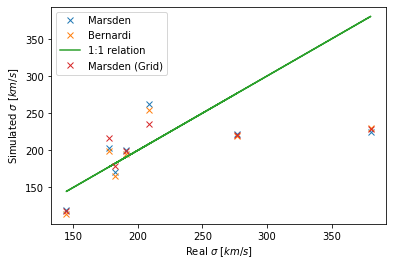

In [18]:
plt.figure()

plt.plot(actual, VD_store, 'x', label='Marsden')

plt.plot(actual, VD_bernardi_store, 'x', label='Bernardi')

plt.plot(actual, actual, label='1:1 relation')

plt.plot(actual, VD_grid_store, 'x', label='Marsden (Grid)')

plt.xlabel("Real $\sigma$ $[km/s]$")
plt.ylabel("Simulated $\sigma$ $[km/s]$")
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(VD_bernardi_store, VD_store, 'x')
plt.plot(VD_bernardi_store, VD_bernardi_store, label = "1:1 relation")

plt.xlabel("$\sigma$ Bernardi $[km/s]$")
plt.ylabel("$\sigma$ Marsden $[km/s]$")
plt.legend()
plt.show()